In [1]:
import sys

import numpy as np
from scipy.optimize import root_scalar

from matplotlib import pyplot as plt, colors, cm

sys.path.append('..')
from sketched.sketched import DiscreteSpectrum, BasicEquivalence

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}')
plt.rcParams['figure.figsize'] = [5.75, 2.5]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['patch.linewidth'] = 0.7
plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

0.08578543762690494


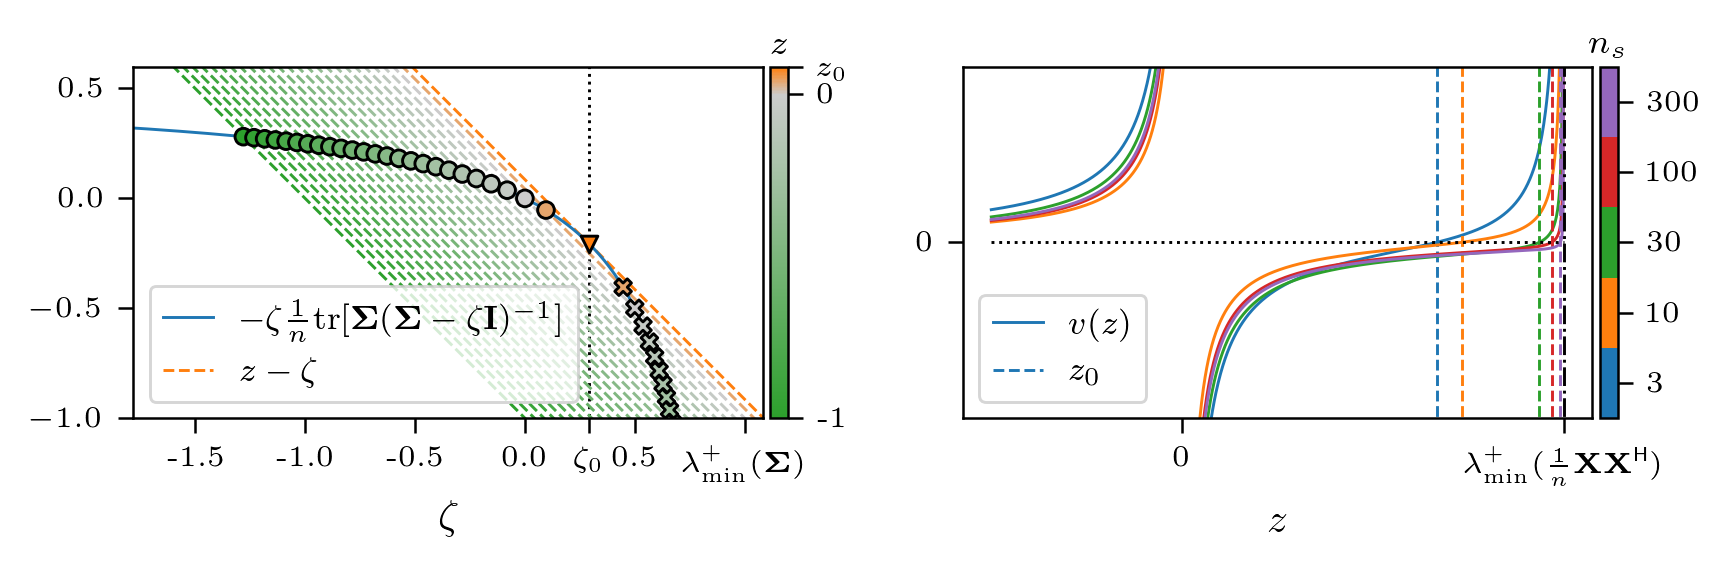

In [3]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(6, 2))

def create_cmap_norm_for_lamdas(z_max, z_min=-1):
    
    norm = colors.Normalize(z_min, z_max)
    cmap = colors.LinearSegmentedColormap.from_list('z_map', [
        (norm(z_min), color_cycle[2]), (norm(0), '#cccccc'), (norm(z_max), color_cycle[1])
    ])
    
    return cmap, norm

p_n = 1/2
ident = DiscreteSpectrum([1])
equiv = BasicEquivalence(ident, p_n)
z_0 = equiv.z_0 - 1e-6
print(z_0)

zs = np.concatenate([np.linspace(-1, 0, int(2 / z_0) + 1), np.linspace(0, z_0, 3)[1:]])
zetas = np.linspace(-5, 1 - 1e-3, 500)
zetas_z = np.linspace(-5, 2)

rhs = p_n * (-zetas) / (1 - zetas)
def lhs(z):
    return z - zetas_z

ax = axes[0]

ax.plot(zetas, rhs, label=r'$-\zeta \frac{1}{n} \mathrm{tr} [\bm{\Sigma} (\bm{\Sigma} - \zeta \mathbf{I})^{-1}]$', zorder=1)
#ax.plot([0, 0], [-5, 5], ':k', zorder=-10)
ax.plot(np.ones(2) * equiv.get_zeta_from_z(z_0), [-5, 5], ':k', zorder=-10)
#ax.plot([-5, 5], [0, 0], ':k', zorder=-10)

cmap, norm = create_cmap_norm_for_lamdas(z_0)
scalar_map = cm.ScalarMappable(norm, cmap=cmap)

def zeta_bad(z):

    def f(zeta):
        return z - zeta + p_n * zeta / (1 - zeta)
    
    res = root_scalar(f, method='brentq', bracket=(equiv.get_zeta_from_z(z_0) + 1e-3, 1 - 1e-3))
    return res.root

zeta_sols = []
zeta_bad_sols = []
for i, z in enumerate(zs):
    zeta = equiv.get_zeta_from_z(z)
    zeta_sols.append(zeta)
    
    if z < z_0:
        zeta_bad_sols.append(zeta_bad(z))
    
    if i == len(zs) - 1:
        ax.plot(zetas_z, lhs(z), '--', color=cmap(norm(z)), label=r'$z - \zeta$', zorder=0)
    else:
        ax.plot(zetas_z, lhs(z), '--', color=cmap(norm(z)), zorder=0)
        
zeta_sols = np.asarray(zeta_sols)
zeta_bad_sols = np.asarray(zeta_bad_sols)
ax.scatter(zeta_sols[:-1], -zeta_sols[:-1] * p_n / (1 - zeta_sols[:-1]), color=cmap(norm(zs[:-1])), edgecolors='black', zorder=2)
ax.scatter(zeta_sols[-1:], -zeta_sols[-1:] * p_n / (1 - zeta_sols[-1:]), marker='v', color=cmap(norm(zs[-1:])), edgecolors='black', zorder=2)
ax.scatter(zeta_bad_sols, -zeta_bad_sols * p_n / (1 - zeta_bad_sols), marker='X', color=cmap(norm(zs[:-1])), edgecolors='black', zorder=2)

ax.axis('equal')
ax.set_xticks([-1.5, -1, -0.5, 0.0, equiv.zeta_0, 0.5, 1], [-1.5, -1.0, -0.5, 0.0, r'$\zeta_0$', 0.5, r'$\lambda_{\min}^+({\bm \Sigma})$'])
ax.set(xlim=(-1, 0.3), ylim=(-1, 0.6))
#ax.set_yticks([-1, 0], [-1, 0])
ax.set_xlabel(r'$\zeta$')

ax.legend(loc='lower left')

cbar = plt.colorbar(scalar_map, ax=ax, ticks=[z_0, 0, -1], pad=0.01)
cbar.ax.set_yticklabels([r'$z_0$', '0', '-1'])
cbar.ax.set_title(r'$z$')

##############################################################

ax = axes[1]

def create_cmap_norm_for_ns(n_max):
    
    norm = colors.Normalize(-0.5, n_max - 0.5)
    cmap = colors.ListedColormap(color_cycle[:n_max])
    
    return cmap, norm

np.random.seed(42)

p_n = 1/2
ns = [3, 10, 30, 100, 300]
n = 1000
p = int(p_n * n)
spec_vec = np.linalg.eigvalsh((lambda X: X @ X.T / n)(np.random.randn(n, p)))
# find biggest scale jump
spec_vec[spec_vec <= 0] = np.min(spec_vec[spec_vec > 0])
i = np.argmax(np.diff(np.log(spec_vec[spec_vec > 0])))
spec_vec[:i + 1] = 0
sigma_minnz = spec_vec[i + 1]
spec_vec_except_minnz = np.concatenate((spec_vec[:i + 1], spec_vec[i + 2:]))

cmap, norm = create_cmap_norm_for_ns(len(ns))
scalar_map = cm.ScalarMappable(norm, cmap=cmap)

for i, n in enumerate(ns):
    this_spec_vec = np.random.choice(spec_vec_except_minnz, size=n - 1, replace=False)
    spectrum = DiscreteSpectrum(np.concatenate((np.asarray([sigma_minnz]), this_spec_vec)))

    zs = np.linspace(-spectrum.min_nz_eigval / 2, spectrum.min_nz_eigval - 1e-12, 1000)
    stieltjes = np.asarray([spectrum.stieltjes_transform(z) for z in zs])

    z_0_i = np.argmin(np.abs(stieltjes))
    z_0 = zs[z_0_i]

    # remove asymptote
    zero_i = np.argmin(np.abs(zs))
    stieltjes[zero_i] = np.nan

    if i == 0:
        ax.plot(zs, stieltjes, color=color_cycle[i], label=r'$v(z)$')
        ax.plot([z_0, z_0], [-1000, 1000], '--', color=color_cycle[i], label='$z_0$')
    else:
        ax.plot(zs, stieltjes, color=color_cycle[i])
        ax.plot([z_0, z_0], [-1000, 1000], '--', color=color_cycle[i])
    
ax.set(ylim=(-100, 100))

ax.plot([sigma_minnz, sigma_minnz], [-1000, 1000], '-.k')
ax.plot(zs, zs * 0, ':k')
ax.set_xticks([0, sigma_minnz], [0, r'$\lambda_{\min}^+(\tfrac{1}{n} \mathbf{X} \mathbf{X}^\textsf{H})$'])
ax.set_yticks([0], [0])
ax.set_xlabel('$z$')
ax.legend(loc='lower left')

cbar = plt.colorbar(scalar_map, ax=ax, ticks=np.arange(len(ns)), pad=0.01)
cbar.ax.set_yticklabels(ns)
cbar.ax.set_title(r'$n_s$')

plt.tight_layout()
plt.savefig('zeta_z_proof_illustration.pdf', bbox_inches='tight')
plt.show()